In [1]:
# %pip uninstall -y numpy pandas pyarrow
# %pip install --upgrade pip setuptools wheel

# # Install compatible versions
# %pip install numpy==1.26.4
# %pip install pandas==2.2.3

# %pip install pyarrow fastparquet


In [2]:
"""
Notebook: 04_generate_embeddings.ipynb
Generate clinical text embeddings using ClinicalT5-large
Run this in Google Colab with GPU for faster processing!
"""

# Cell 1: Setup and GPU Check
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from pathlib import Path
import json
from tqdm.auto import tqdm
# Install h5py
%pip install h5py
import h5py
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("   ⚠️  No GPU available - this will be slow!")
    print("   Consider using Google Colab with GPU runtime")



c:\Users\91903\OneDrive\Desktop\1111198\IIII\FinalProject\Patient\trance-project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



🖥️  Using device: cuda
   GPU: NVIDIA GeForce RTX 3050 Laptop GPU
   Memory: 4.29 GB


In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)           # Should show 12.8
print(torch.cuda.is_available())    # Should be True
print(torch.cuda.get_device_name(0))  # Should show "NVIDIA GeForce RTX 3050"


2.8.0+cu128
12.8
True
NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
# Cell 2: Load Configuration and Data
"""
Load cohort and configuration
"""
# If running in Colab, mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = Path('/content/drive/MyDrive/TRANCE')  # Adjust path
    print("✓ Google Drive mounted")
except:
    base_path = Path('..')  # Local path
    print("✓ Using local path")

# Load config
config_path = base_path / 'configs/config.json'
with open(config_path, 'r') as f:
    config = json.load(f)

# Load cohort with discharge notes
cohort_path = base_path / 'data/processed/cohort_with_outcomes.parquet'
cohort = pd.read_parquet(cohort_path)

print(f"✓ Loaded cohort: {len(cohort)} admissions")
print(f"   With discharge notes: {cohort['HAS_DISCHARGE_NOTE'].sum()}")

# Filter to admissions with notes
cohort_with_notes = cohort[cohort['HAS_DISCHARGE_NOTE']].copy()
print(f"✓ Processing {len(cohort_with_notes)} admissions with notes")



✓ Using local path
✓ Loaded cohort: 79 admissions
   With discharge notes: 79
✓ Processing 79 admissions with notes


In [5]:
# %pip install huggingface_hub[hf_xet]

# %pip install --upgrade pip
# %pip install --upgrade "jax[cuda12]" -f https://storage.googleapis.com/jax-releases/jax_releases.html

# %pip install flax

# %pip install transformers[flax]


In [ ]:
# import jax
# print(jax.default_backend())   # should print 'gpu'
# print(jax.devices())           # should list your GPU (e.g. NVIDIA GeForce RTX 3060)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


cpu
[CpuDevice(id=0)]


In [7]:
# Cell 3: Load ClinicalT5 Model (PyTorch from Flax)
"""
Load pre-trained ClinicalT5-large model and tokenizer
"""
model_name = config['model']['embedding_model']
print(f"Loading model: {model_name}")
print("This may take a few minutes on first run...")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model from Flax weights and move to device
try:
    model = AutoModel.from_pretrained(model_name, from_flax=True)
except Exception as e:
    print("Error loading Flax model. Make sure jax and flax are installed.")
    raise e

model = model.to(device)
model.eval()

print(f"✓ Model loaded successfully")
print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Embedding dimension: {config['model']['embedding_dim']}")
print(f"   Device: {device}")


Loading model: luqh/ClinicalT5-large
This may take a few minutes on first run...


All Flax model weights were used when initializing T5Model.

Some weights of T5Model were not initialized from the Flax model and are newly initialized: ['decoder.embed_tokens.weight', 'encoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded successfully
   Model parameters: 737,668,096
   Embedding dimension: 768
   Device: cuda


In [8]:
# Cell 4: Text Preprocessing Function
"""
Preprocess clinical notes for embedding generation
"""
def preprocess_text(text):
    """
    Clean and preprocess clinical text
    """
    if pd.isna(text):
        return ""
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove excessive whitespace
    text = ' '.join(text.split())
    
    # Remove very short texts
    if len(text) < 5:
        return ""
    
    # Truncate very long texts (handle in chunking instead)
    # We'll chunk properly in the next step
    
    return text


# Ensure the column exists
if 'DISCHARGE_TEXT' not in cohort_with_notes.columns:
    raise KeyError("Column 'DISCHARGE_TEXT' not found. Available columns: " + str(cohort_with_notes.columns))

# Keep only rows with non-null discharge text
cohort_with_notes = cohort_with_notes[cohort_with_notes['DISCHARGE_TEXT'].notna()].copy()
print(f"✓ {len(cohort_with_notes)} notes available before preprocessing")

# Apply preprocessing
cohort_with_notes['PROCESSED_TEXT'] = cohort_with_notes['DISCHARGE_TEXT'].apply(preprocess_text)

# Remove empty texts
cohort_with_notes = cohort_with_notes[cohort_with_notes['PROCESSED_TEXT'] != ""].copy()
print(f"✓ {len(cohort_with_notes)} notes after preprocessing")

# Analyze text lengths
cohort_with_notes['TEXT_LENGTH'] = cohort_with_notes['PROCESSED_TEXT'].str.len()
print(f"\nText length statistics:")
print(cohort_with_notes['TEXT_LENGTH'].describe())



✓ 79 notes available before preprocessing
✓ 79 notes after preprocessing

Text length statistics:
count       79.000000
mean      2445.746835
std       2542.379506
min        367.000000
25%       1444.000000
50%       2058.000000
75%       2698.500000
max      21910.000000
Name: TEXT_LENGTH, dtype: float64


In [9]:
# Cell 5: Text Chunking Strategy
"""
Implement sliding window chunking for long texts
"""
max_length = config['model']['max_text_length']
overlap = config['model']['chunk_overlap']

def chunk_text(text, tokenizer, max_length=512, overlap=128):
    """
    Split long text into overlapping chunks
    Returns list of token IDs for each chunk
    """
    # Tokenize full text
    tokens = tokenizer.encode(text, add_special_tokens=False)
    
    if len(tokens) <= max_length:
        # Short text - return as single chunk with special tokens
        return [tokenizer.encode(text, max_length=max_length, truncation=True)]
    
    # Long text - create sliding windows
    chunks = []
    stride = max_length - overlap
    
    for i in range(0, len(tokens), stride):
        chunk_tokens = tokens[i:i + max_length]
        
        # Add special tokens
        chunk_ids = tokenizer.build_inputs_with_special_tokens(chunk_tokens)
        chunks.append(chunk_ids)
        
        # Stop if we've covered the text
        if i + max_length >= len(tokens):
            break
    
    return chunks

# Test chunking only if there are notes
if len(cohort_with_notes) > 0:
    print("Testing chunking strategy...")
    sample_text = cohort_with_notes.iloc[0]['PROCESSED_TEXT']
    sample_chunks = chunk_text(sample_text, tokenizer, max_length, overlap)
    print(f"Sample text length: {len(sample_text)} characters")
    print(f"Number of chunks: {len(sample_chunks)}")
    print(f"Tokens per chunk: {[len(c) for c in sample_chunks]}")
else:
    print("⚠️  No notes available to test chunking.")


Testing chunking strategy...
Sample text length: 1814 characters
Number of chunks: 2
Tokens per chunk: [513, 401]


In [14]:
"""
Cell 6: Batch Embedding Generation Function
Generate embeddings with batching for efficiency (T5 encoder-only)
"""
@torch.no_grad()
def generate_embeddings(texts, tokenizer, model, batch_size=8, max_length=512, overlap=128):
    """
    Generate embeddings for a list of texts using the encoder part of T5/ClinicalT5.
    Returns: numpy array of embeddings (n_texts, embedding_dim)
    """
    all_embeddings = []

    for text in tqdm(texts, desc="Generating embeddings"):
        # Chunk long text into overlapping segments
        chunks = chunk_text(text, tokenizer, max_length, overlap)

        if len(chunks) == 0:
            embedding = np.zeros(config['model']['embedding_dim'])
            all_embeddings.append(embedding)
            continue

        chunk_embeddings = []

        for i in range(0, len(chunks), batch_size):
            batch_chunks = chunks[i:i + batch_size]
            max_len = max(len(c) for c in batch_chunks)

            padded_chunks = [c + [tokenizer.pad_token_id] * (max_len - len(c))
                             for c in batch_chunks]
            attention_mask = [[1] * len(c) + [0] * (max_len - len(c))
                              for c in batch_chunks]

            input_ids = torch.tensor(padded_chunks).to(device)
            attention_mask = torch.tensor(attention_mask).to(device)

            # ✅ Encoder-only forward pass (fix for T5/ClinicalT5)
            encoder_outputs = model.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            embeddings = encoder_outputs.last_hidden_state

            # Mean pooling with attention mask
            mask_expanded = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
            sum_embeddings = torch.sum(embeddings * mask_expanded, 1)
            sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
            chunk_emb = (sum_embeddings / sum_mask).cpu().numpy()

            chunk_embeddings.append(chunk_emb)

        chunk_embeddings = np.vstack(chunk_embeddings)
        final_embedding = np.mean(chunk_embeddings, axis=0)
        all_embeddings.append(final_embedding)

    return np.array(all_embeddings)

print("✓ Embedding generation function ready (Encoder-only for ClinicalT5)")


✓ Embedding generation function ready (Encoder-only for ClinicalT5)


In [15]:
# Cell 7: Generate Embeddings for All Notes
"""
Process all clinical notes - this is the main computation
"""
print("\n" + "="*60)
print("GENERATING CLINICAL TEXT EMBEDDINGS")
print("="*60)

# Batch size - adjust based on GPU memory
batch_size = 16 if torch.cuda.is_available() else 4

print(f"\nProcessing {len(cohort_with_notes)} clinical notes...")
print(f"Batch size: {batch_size}")
print(f"Max length: {max_length} tokens")
print(f"Overlap: {overlap} tokens")
print("\nThis may take 10-30 minutes depending on GPU...")

# Generate embeddings
texts = cohort_with_notes['PROCESSED_TEXT'].tolist()
embeddings = generate_embeddings(
    texts, 
    tokenizer, 
    model, 
    batch_size=batch_size,
    max_length=max_length,
    overlap=overlap
)

print(f"\n✓ Generated embeddings")
print(f"   Shape: {embeddings.shape}")
print(f"   Memory: {embeddings.nbytes / 1e6:.2f} MB")



GENERATING CLINICAL TEXT EMBEDDINGS

Processing 79 clinical notes...
Batch size: 16
Max length: 512 tokens
Overlap: 128 tokens

This may take 10-30 minutes depending on GPU...


Generating embeddings: 100%|██████████| 79/79 [01:27<00:00,  1.11s/it]


✓ Generated embeddings
   Shape: (79, 1024)
   Memory: 0.32 MB


In [16]:
# Cell 8: Quality Checks
"""
Validate embedding quality
"""
print("\n" + "="*60)
print("EMBEDDING QUALITY CHECKS")
print("="*60)

# Check for zero vectors
zero_vectors = np.all(embeddings == 0, axis=1).sum()
print(f"Zero vectors: {zero_vectors} ({zero_vectors/len(embeddings)*100:.2f}%)")

# Check for NaN or Inf
nan_vectors = np.any(np.isnan(embeddings), axis=1).sum()
inf_vectors = np.any(np.isinf(embeddings), axis=1).sum()
print(f"NaN vectors: {nan_vectors}")
print(f"Inf vectors: {inf_vectors}")

# Embedding statistics
print(f"\nEmbedding statistics:")
print(f"  Mean: {embeddings.mean():.4f}")
print(f"  Std:  {embeddings.std():.4f}")
print(f"  Min:  {embeddings.min():.4f}")
print(f"  Max:  {embeddings.max():.4f}")

# Check embedding norms
norms = np.linalg.norm(embeddings, axis=1)
print(f"\nEmbedding norms:")
print(f"  Mean: {norms.mean():.4f}")
print(f"  Std:  {norms.std():.4f}")
print(f"  Min:  {norms.min():.4f}")
print(f"  Max:  {norms.max():.4f}")




EMBEDDING QUALITY CHECKS
Zero vectors: 0 (0.00%)
NaN vectors: 0
Inf vectors: 0

Embedding statistics:
  Mean: 0.0019
  Std:  0.0855
  Min:  -0.5834
  Max:  0.6497

Embedding norms:
  Mean: 2.7338
  Std:  0.0938
  Min:  2.4078
  Max:  2.9841



VISUALIZING EMBEDDING SPACE
Running t-SNE on 79 embeddings...
✓ Visualization saved


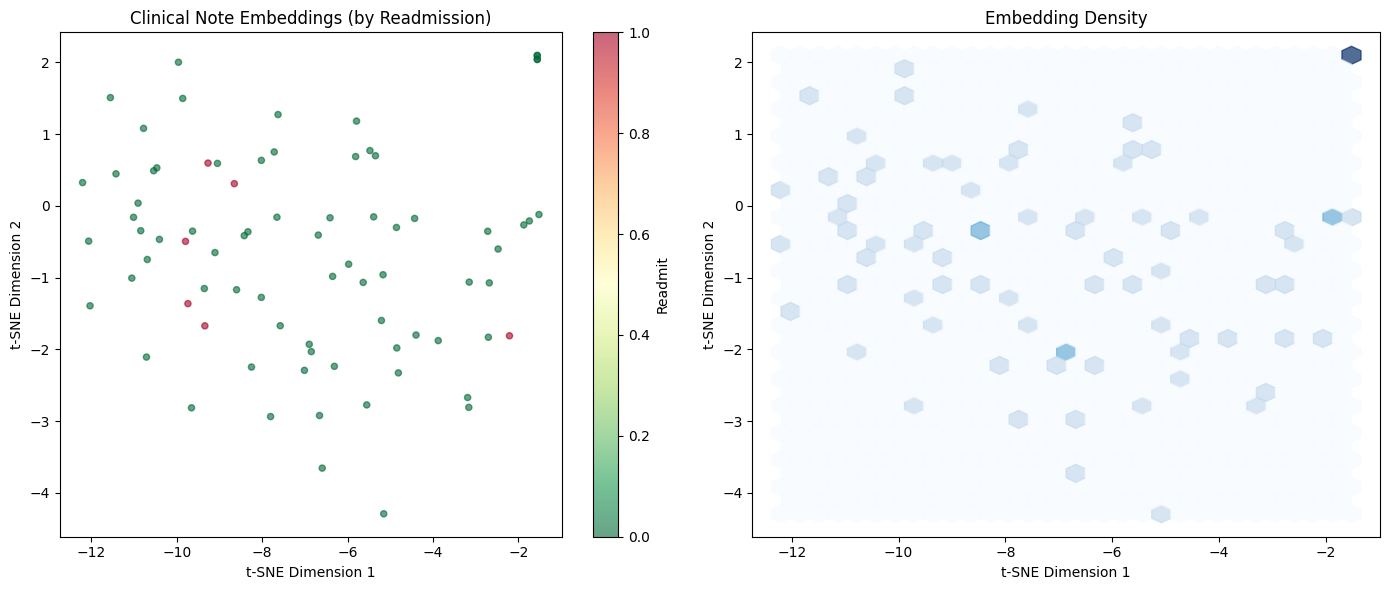

In [17]:
# Cell 9: Visualize Embedding Space (Sample)
"""
Visualize embeddings using t-SNE/UMAP
"""
print("\n" + "="*60)
print("VISUALIZING EMBEDDING SPACE")
print("="*60)

# Sample for visualization (1000 points max for speed)
n_viz = min(1000, len(embeddings))
viz_indices = np.random.choice(len(embeddings), n_viz, replace=False)
viz_embeddings = embeddings[viz_indices]

# Use t-SNE for dimensionality reduction
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

print(f"Running t-SNE on {n_viz} embeddings...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(viz_embeddings)

# Get readmission labels for coloring
viz_cohort = cohort_with_notes.iloc[viz_indices]
viz_labels = viz_cohort['READMIT_30'].fillna(False).astype(int)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Colored by readmission
scatter = axes[0].scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1],
    c=viz_labels,
    cmap='RdYlGn_r',
    alpha=0.6,
    s=20
)
axes[0].set_title('Clinical Note Embeddings (by Readmission)')
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')
plt.colorbar(scatter, ax=axes[0], label='Readmit')

# Plot 2: Density
axes[1].hexbin(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    gridsize=30,
    cmap='Blues',
    alpha=0.7
)
axes[1].set_title('Embedding Density')
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')

plt.tight_layout()
plt.savefig(base_path / 'outputs/figures/embedding_visualization.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved")
plt.show()


In [18]:
# Cell 10: Save Embeddings
"""
Save embeddings in HDF5 format for efficient storage and retrieval
"""
print("\n" + "="*60)
print("SAVING EMBEDDINGS")
print("="*60)

# Create embedding dataframe
embedding_df = pd.DataFrame({
    'HADM_ID': cohort_with_notes['HADM_ID'].values,
    'SUBJECT_ID': cohort_with_notes['SUBJECT_ID'].values
})

# Save embeddings as HDF5 (efficient for large arrays)
embeddings_path = base_path / 'data/embeddings/discharge_note_embeddings.h5'
embeddings_path.parent.mkdir(parents=True, exist_ok=True)

with h5py.File(embeddings_path, 'w') as f:
    # Save embeddings
    f.create_dataset('embeddings', data=embeddings, compression='gzip')
    
    # Save HADM_IDs for mapping
    f.create_dataset('hadm_ids', data=cohort_with_notes['HADM_ID'].values)
    
    # Save metadata
    f.attrs['n_admissions'] = len(embeddings)
    f.attrs['embedding_dim'] = embeddings.shape[1]
    f.attrs['model'] = model_name
    f.attrs['max_length'] = max_length
    f.attrs['overlap'] = overlap

print(f"✓ Saved embeddings to: {embeddings_path}")
print(f"   Size: {embeddings_path.stat().st_size / 1e6:.2f} MB")

# Also save as parquet with embedding columns for easy merging
embedding_cols = [f'emb_{i}' for i in range(embeddings.shape[1])]
emb_df = pd.DataFrame(embeddings, columns=embedding_cols)
emb_df['HADM_ID'] = cohort_with_notes['HADM_ID'].values

emb_parquet_path = base_path / 'data/embeddings/embeddings.parquet'
emb_df.to_parquet(emb_parquet_path, index=False)
print(f"✓ Also saved as parquet: {emb_parquet_path}")




SAVING EMBEDDINGS
✓ Saved embeddings to: ..\data\embeddings\discharge_note_embeddings.h5
   Size: 0.31 MB
✓ Also saved as parquet: ..\data\embeddings\embeddings.parquet


In [19]:
# Cell 11: Create Embedding Summary
"""
Save summary statistics and metadata
"""
summary = {
    'model': model_name,
    'embedding_dimension': int(embeddings.shape[1]),
    'n_admissions_with_embeddings': int(len(embeddings)),
    'processing': {
        'max_length': max_length,
        'overlap': overlap,
        'batch_size': batch_size,
        'device': str(device)
    },
    'quality_metrics': {
        'zero_vectors': int(zero_vectors),
        'nan_vectors': int(nan_vectors),
        'inf_vectors': int(inf_vectors),
        'mean_norm': float(norms.mean()),
        'std_norm': float(norms.std())
    },
    'statistics': {
        'mean': float(embeddings.mean()),
        'std': float(embeddings.std()),
        'min': float(embeddings.min()),
        'max': float(embeddings.max())
    }
}

summary_path = base_path / 'outputs/results/embedding_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✓ Saved summary: {summary_path}")



✓ Saved summary: ..\outputs\results\embedding_summary.json


In [20]:
# Cell 12: Merge with Feature Sets
"""
Create fused datasets with both structured features and embeddings
"""
print("\n" + "="*60)
print("CREATING FUSED DATASETS")
print("="*60)

# Load structured features
train_features = pd.read_parquet(base_path / 'data/processed/train_features.parquet')
calib_features = pd.read_parquet(base_path / 'data/processed/calibration_features.parquet')
test_features = pd.read_parquet(base_path / 'data/processed/test_features.parquet')

print(f"Loaded structured features:")
print(f"  Train: {train_features.shape}")
print(f"  Calib: {calib_features.shape}")
print(f"  Test:  {test_features.shape}")

# Merge with embeddings
train_fused = train_features.merge(emb_df, on='HADM_ID', how='left')
calib_fused = calib_features.merge(emb_df, on='HADM_ID', how='left')
test_fused = test_features.merge(emb_df, on='HADM_ID', how='left')

# For admissions without notes, fill embeddings with zeros
embedding_cols = [c for c in emb_df.columns if c.startswith('emb_')]
for col in embedding_cols:
    train_fused[col] = train_fused[col].fillna(0)
    calib_fused[col] = calib_fused[col].fillna(0)
    test_fused[col] = test_fused[col].fillna(0)

print(f"\nFused datasets:")
print(f"  Train: {train_fused.shape}")
print(f"  Calib: {calib_fused.shape}")
print(f"  Test:  {test_fused.shape}")

# Check embedding coverage
print(f"\nEmbedding coverage:")
print(f"  Train: {(train_fused[embedding_cols[0]] != 0).sum()}/{len(train_fused)} ({(train_fused[embedding_cols[0]] != 0).mean()*100:.1f}%)")
print(f"  Calib: {(calib_fused[embedding_cols[0]] != 0).sum()}/{len(calib_fused)} ({(calib_fused[embedding_cols[0]] != 0).mean()*100:.1f}%)")
print(f"  Test:  {(test_fused[embedding_cols[0]] != 0).sum()}/{len(test_fused)} ({(test_fused[embedding_cols[0]] != 0).mean()*100:.1f}%)")

# Save fused datasets
train_fused.to_parquet(base_path / 'data/processed/train_fused.parquet', index=False)
calib_fused.to_parquet(base_path / 'data/processed/calibration_fused.parquet', index=False)
test_fused.to_parquet(base_path / 'data/processed/test_fused.parquet', index=False)

print(f"\n✓ Saved fused datasets")




CREATING FUSED DATASETS
Loaded structured features:
  Train: (14, 88)
  Calib: (2, 88)
  Test:  (5, 88)

Fused datasets:
  Train: (14, 1112)
  Calib: (2, 1112)
  Test:  (5, 1112)

Embedding coverage:
  Train: 14/14 (100.0%)
  Calib: 2/2 (100.0%)
  Test:  5/5 (100.0%)

✓ Saved fused datasets


In [21]:
# Cell 13: Update Feature Info
"""
Update feature metadata to include embeddings
"""
with open(base_path / 'data/processed/feature_info.json', 'r') as f:
    feature_info = json.load(f)

feature_info['embedding_features'] = {
    'n_dimensions': len(embedding_cols),
    'column_names': embedding_cols,
    'model': model_name,
    'coverage_train': float((train_fused[embedding_cols[0]] != 0).mean()),
    'coverage_test': float((test_fused[embedding_cols[0]] != 0).mean())
}

feature_info['total_fused_features'] = len(feature_info['feature_names']) + len(embedding_cols)

with open(base_path / 'data/processed/feature_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)

print("✓ Updated feature metadata")


✓ Updated feature metadata


In [22]:
# Cell 14: Memory Cleanup
"""
Clear GPU memory
"""
if torch.cuda.is_available():
    del model
    torch.cuda.empty_cache()
    print("\n✓ GPU memory cleared")



✓ GPU memory cleared


In [23]:
# Cell 15: Summary
print("\n" + "="*60)
print("EMBEDDING GENERATION COMPLETE!")
print("="*60)
print(f"\n✅ Generated {embeddings.shape[0]} embeddings")
print(f"✅ Embedding dimension: {embeddings.shape[1]}")
print(f"✅ Created fused datasets with structured + text features")
print(f"\n📊 Outputs:")
print(f"   - data/embeddings/discharge_note_embeddings.h5")
print(f"   - data/embeddings/embeddings.parquet")
print(f"   - data/processed/train_fused.parquet")
print(f"   - data/processed/calibration_fused.parquet")
print(f"   - data/processed/test_fused.parquet")
print(f"   - outputs/figures/embedding_visualization.png")
print(f"   - outputs/results/embedding_summary.json")
print(f"\n📝 Next Steps:")
print("   1. Train baseline model (structured features only)")
print("   2. Train fused model (structured + embeddings)")
print("   3. Compare performance")
print("   4. Proceed to notebook 05_train_models.ipynb")


EMBEDDING GENERATION COMPLETE!

✅ Generated 79 embeddings
✅ Embedding dimension: 1024
✅ Created fused datasets with structured + text features

📊 Outputs:
   - data/embeddings/discharge_note_embeddings.h5
   - data/embeddings/embeddings.parquet
   - data/processed/train_fused.parquet
   - data/processed/calibration_fused.parquet
   - data/processed/test_fused.parquet
   - outputs/figures/embedding_visualization.png
   - outputs/results/embedding_summary.json

📝 Next Steps:
   1. Train baseline model (structured features only)
   2. Train fused model (structured + embeddings)
   3. Compare performance
   4. Proceed to notebook 05_train_models.ipynb
